In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
from six import iteritems
import shelve
from scipy.ndimage.measurements import label
import h5py
import json
import sys 
import operator 
from scipy import ndimage

from pdb import set_trace as st
import copy
import os
#from IPython.display import Image, display
from ipywidgets import interact, fixed
from IPython.display import display
import ipywidgets as widgets
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import os
from os.path import expanduser
import time

import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, ConcatDataset
from torch.nn.parallel import data_parallel
from torchvision import transforms

import random
import six

import importlib

import artificery
import metroem
importlib.reload(metroem)
import torchfields

from metroem import loss
from metroem import masks
from metroem import alignment
from metroem import aligner
from metroem import train
from metroem import helpers
from metroem import dataset

importlib.reload(helpers)
importlib.reload(aligner)
importlib.reload(alignment)
importlib.reload(masks)
importlib.reload(loss)
importlib.reload(train)
importlib.reload(dataset)

from metroem.alignment import align_sample
from metroem.loss import similarity_score, smoothness_penalty, get_dataset_loss, get_mse_and_smoothness_masks, smoothness_score
from metroem.helpers import reverse_dim, downsample

def visualize_residuals(res, figsize=(10,10), x_coords=None, y_coords=None, vec_grid=50):
    res = prepare_for_show(res)
    if res.shape[0] == 2:
        res = np.transpose(res, (1, 2, 0))

    assert res.shape[0] == res.shape[1]
    plt.figure(figsize=figsize)
    n = res.shape[0]
    y, x = np.mgrid[0:n, 0:n]
    
    if x_coords is None:
        x_coords = [0, res.shape[0]]
    if y_coords is None:
        y_coords = [0, res.shape[1]]
    
    ex = (1) * res[:, :, 0]
    ey = res[:, :, 1]
    r = np.arctan2(ex, ey)
    
    interval = (x_coords[1] - x_coords[0]) // vec_grid
    
    plt.quiver(  x[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval],  
                 y[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval],
                ex[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], 
                ey[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], 
                 r[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], alpha=0.6)
    plt.quiver(x[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval],  
                 y[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval],
                ex[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], 
                ey[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], edgecolor='k', facecolor='None', linewidth=.5)
    plt.gca().invert_yaxis()

def visualize_histogram(data, figsize=(10,10), x_coords=None, y_coords=None):
    pass
    
def get_np(pt):
    return pt.cpu().detach().numpy()


def prepare_for_show(img):
    if isinstance(img, torch.Tensor):
         img = get_np(img)
    img = img.squeeze()
    return img


rand_cmap = matplotlib.colors.ListedColormap(np.random.rand(256*32,3))

def display_image(img, x_coords=None, y_coords=None, normalize=False, figsize=(10, 10), mask=False, segmentation=False):
    if normalize and mask:
        raise Exception("Masks can't be normalized")
    img = prepare_for_show(img)

    if len(img.shape) == 3 and img.shape[-1] == 2:
        visualize_residuals(img, x_coords=x_coords, y_coords=y_coords)
        return
    
    plt.figure(figsize=figsize)
    
    if x_coords is None:
        x_coords = [0, img.shape[0]]
    if y_coords is None:
        y_coords = [0, img.shape[1]]
    
    if mask:
        plt.imshow(img[x_coords[0]:x_coords[1], y_coords[0]:y_coords[1]], cmap='gray')
    elif segmentation:
        cmap='gray'
        cmap = rand_cmap
        
        plt.imshow(img[x_coords[0]:x_coords[1], y_coords[0]:y_coords[1]].astype(np.int32), cmap=cmap)
    elif not normalize:
        plt.imshow(img[x_coords[0]:x_coords[1], y_coords[0]:y_coords[1]], cmap='gray', vmin=-1.5, vmax=1.5)
    else:
        plt.imshow(img[x_coords[0]:x_coords[1], y_coords[0]:y_coords[1]], cmap='gray')

        
def precompute_state(self, img_id, sup, val, state_file):
    self.compute_state(img_id, sup, val)
    try:
        
        state_h5 = h5py.File(state_file, 'w')
        img_shape = self.src.shape
        dset_shape = [0, 100, img_shape[3], img_shape[4]]
        if "main" not in state_h5:
            src_h5 = state_h5.create_dataset("main/src", dset_shape)
            tgt_h5 = state_h5.create_dataset("main/tgt", dset_shape)
            pred_tgt_h5 = state_h5.create_dataset("main/pred_tgt_h5", dset_shape)
        else:
            src_h5 = state_h5["main/src"]
            tgt_h5 = state_h5["main/tgt"]
            pred_tgt_h5 = state_h5["main/pred_tgt"]
        src_h5[:, img_id:img_id+1, :, :] = 0#self.src 
        tgt_h5[:, img_id:img_id+1, :, :] = 0#self.tgt
        pred_tgt_h5[:, img_id:img_id+1, :, :] = 0#self.pred_tgt_h5
        state_h5.close()
    except Exception as e:
        state_h5.close()
        raise e

def filter_folds(viz_mse_mask_var, input_mip=6):
    downsampler = nn.AvgPool2d(2) 
    for i in range(input_mip, 8):
        viz_mse_mask_var = downsampler(viz_mse_mask_var)
        
    viz_mse_mask_var = (viz_mse_mask_var < 0.3).type(torch.cuda.DoubleTensor)
                           
    viz_mse_mask_var = viz_mse_mask_var.type(torch.cuda.ByteTensor)
    mse_mask_np = get_np(viz_mse_mask_var.squeeze())
    filtered_mse_mask_np = filter_connected_component(mse_mask_np, 100) == 0
    return filtered_mse_mask_np

        
def segment_folds(fold_mask_np, memory_limit=None):
    initial_segments = get_initial_segments(fold_mask_np, memory_limit)
    segments  = cleanup_segment_stripes(initial_segments, n=16)
    return segments

def cleanup_segment_stripes(segments, n):
    seg_t = np.copy(segments.T)
    seg_start = np.zeros_like(seg_t[0])
    last_seg = np.zeros_like(seg_t[1])
    last_cleanup = 0
    
    for i in range(1, seg_t.shape[0]): 
        is_fold = seg_t[i] == 0
        was_fold = seg_t[i - 1] == 0
        last_seg_fold = last_seg == 0
        
        new_seg = (seg_t[i] != seg_t[i - 1])
        seg_width = i - seg_start
        
        bad_seg = new_seg * (seg_width < n) * (was_fold == False) * (is_fold == False)
        bad_seg_names = np.unique(seg_t[i - 1][bad_seg])
        
        if len(bad_seg_names) > 0:
            print (i, last_cleanup, bad_seg_names)
            cleanup_seg_id = i - 2
            ref_seg_id = i - 1

            ids_to_clean = None
            change_to_these = np.maximum(last_seg, new_seg)
            while (cleanup_seg_id >= 0):
                ids_to_clean = (seg_t[cleanup_seg_id] == seg_t[ref_seg_id]) * bad_seg * (last_seg_fold == False)
                if np.any(ids_to_clean) == False:
                    break
                seg_t[cleanup_seg_id][ids_to_clean] = change_to_these[ids_to_clean]
                cleanup_seg_id -= 1
            seg_t[ref_seg_id][bad_seg * (last_seg_fold == False)] = change_to_these[bad_seg * (last_seg_fold == False)]
            last_cleanup = i
                                  
        last_seg[new_seg] = seg_t[i - 1][new_seg]
        seg_start[new_seg] = i
    return seg_t.T

def get_initial_segments(fold_mask_np, memory_limit, smallest_seg):
    folds = fold_mask_np == False
    segments = np.zeros_like(folds, dtype=np.int32)
    last_fold = np.zeros_like(folds[0], dtype=np.int32)
    seg_start = np.zeros_like(folds[0], dtype=np.int32)
    
    segments[0] = 1
    segments[0][folds[0]] = 0
    max_in_line = np.copy(segments[0])
    
    
    for i in range(1, folds.shape[0]):
        
        
        is_fold = folds[i]
        was_fold = folds[i - 1]
        curr_seg = segments[i]
        last_seg = segments[i - 1]
        
        continue_ids = (is_fold == False) * (was_fold == False)
        short_stretch = (i - seg_start) < smallest_seg
        
        new_seg_ids = (is_fold == False) * (was_fold == True) * (short_stretch == False)
        jump_seg_ids = (is_fold == False) * (was_fold == True) * (short_stretch == True)
        
        curr_seg[continue_ids] = last_seg[continue_ids]
        curr_seg[new_seg_ids] = (max_in_line + 1)[new_seg_ids]
        
        fresh_start_ids = max_in_line == 0
        curr_seg[jump_seg_ids * (fresh_start_ids == False)] = max_in_line[jump_seg_ids * (fresh_start_ids == False)]
        curr_seg[jump_seg_ids * (fresh_start_ids == True)] = (max_in_line + 1)[jump_seg_ids * (fresh_start_ids == True)]
        
        seg_start[new_seg_ids] = i
        
        curr_seg[is_fold == True] = 0
        max_in_line = np.maximum(max_in_line, curr_seg)
        
        '''if memory_limit is not None:
            forgotten_folds = (i - last_fold) > memory_limit
            max_in_line[forgotten_folds] = np.maximum(1, max_in_line[forgotten_folds] - 1)'''
        last_fold[is_fold] = i
        
    return segments 

def expand_mask(mask_np, n=33):
    mask_var = torch.FloatTensor(mask_np.astype(np.float)).unsqueeze(0).unsqueeze(0)
    kernel = torch.ones([1, 1, n, n])
    expanded_mask = torch.nn.functional.conv2d(mask_var, kernel, padding=n//2) 
    expanded_mask_np = get_np(expanded_mask[0, 0]) > 0
    return expanded_mask_np

class PyramidVisualizer(object):
    def __init__(self, pyramid, def_sup=False):
        self.reverse = True
        self.fold_size = None
        self.src = None
        self.prev_id = -1
        self.prev_is_val = False
        self.prev_is_sup = False
        self.val_dataset = None
        self.train_dataset = None
        self.def_sup = True
        self.def_norm_img = False
        self.viz_mip = 0
        self.run_mip = 0
        self.sup = False
        self.prerun_augment = []
        
        self.pyramid = pyramid
        self.run_mip = 0
        self.viz_mip = 0
        
        
        self.dataset_mip, self.sup_train_dataset = get_datasets()
        #self.upsampler = nn.UpsamplingBilinear2d(scale_factor=2)   
        self.mse_keys_to_apply = {
        'src': [
            {'name': 'src_defects',
             'binarization': {'strat': 'eq', 'value': 0},
             "not_coarsen_ranges": [ (0,25)] },
            {'name': 'src',
             "not_coarsen_ranges": [(1, 0)],
             'binarization': {'strat': 'neq', 'value': 0}
             }
            ],
        'tgt':[
            {'name': 'tgt_defects',
             'binarization': {'strat': 'eq', 'value': 0},
             "coarsen_ranges": [(0, 0)]},
            {'name': 'tgt',
             "not_coarsen_ranges": [(10, 0)],
             'binarization': {'strat': 'neq', 'value': 0}
             }
        ]
    }
        self.sm_keys_to_apply = {                                                                                                 
           "src": [                                                                                                          
               {"name": "src_defects",                                                                                      
                "binarization": {"strat": "eq", "value": 0},                                                               
                "not_coarsen_ranges": [[1, 0.2], [4, 5.0]],                                                             
                "mask_value": 1.0e-5},                                                                                       
             {"name": "src",                                                                                             
                "fm": 0,                                                                                                  
                "binarization": {"strat": "neq", "value": 0}}                                                            
           ],                                                                                                              
           "tgt":[                                                                                                        
               {"name": "tgt_defects",                                                                                   
                "binarization": {"strat": "eq", "value": 0},                                                                 
                #"not_coarsen_ranges": [[1, 0.2], [2, 0.4], [3, 0.6], [4, 0.8]],                                                              
                "mask_value": 0.0e-5}                                                                                         
           ]                                                                                                              
       }
        
    
        
    def set_model(self, model):
        self.pyramid = model
        self.prev_id = -1
    
    def update_state(self, img_id, sup, val, state_file):
        if state_file is None:
            
            self.compute_state(img_id, sup, val)
        else:
            self.load_state(img_id, sup, val, state_file)
            
    def compute_state(self, img_id, sup, val):
        self.dataset = self.sup_train_dataset
                
        if self.prev_id == -1:
            self.clean_up()
            
        #make it refresh when sup is changed
        if self.prev_id == -1 or self.prev_is_sup != sup:
            self.prev_is_sup = sup
            self.prev_id = -1
            

        if img_id != self.prev_id or self.prev_is_val != val:
            self.prev_id = img_id
            self.prev_is_val = val
            #clean_sample = self.dataset[img_id][:, 2:-30, 2:-30].unsqueeze(0)
            
            raw_sample = copy.deepcopy(self.dataset[img_id])
           
            for aug in self.prerun_augment:
                if aug['type'] == 'contrast_half_src':
                    src = raw_sample[0, 0]
                    src[src.shape[0]//2:, :] *= aug['mult']
                elif aug['type'] == 'brightness_half_src':
                    src = raw_sample[0, 0]
                    src[src.shape[0]//2:, :] += aug['bump']
                else:
                    raise Exception("Unknown prerun transofm")
                    
            for k, v in six.iteritems(raw_sample):
                #print (v.shape)
                # why are we doing this
                raw_sample[k] = v.unsqueeze(0)  
                
            run_sample = copy.deepcopy(raw_sample)
            self.run_sample = run_sample
            for k, v in six.iteritems(run_sample):
                #print (v.shape)
                # why are we doing this: to have the same orientation as ng
                #run_sample[k] = v.permute(0, 2, 1)
                pass
            
            model_run_params = {"level_in": self.run_mip}
            
            run_result = align_sample(self.pyramid, run_sample)
            for k, v in six.iteritems(run_result):
                if hasattr(v, 'detach'):
                    run_result[k] = v.detach()
                
            run_src_var = run_result['src'].unsqueeze(0)                                                                   
            run_tgt_var = run_result['tgt'].unsqueeze(0)                                                                                                                             
            run_pred_res_var = run_result['pred_res']                                                                
            del run_result
            
            '''run_result = self.pyramid.run_pair(run_sample.unsqueeze(0), self.run_mip, reverse=self.reverse)
            run_src_var, run_tgt_var, run_true_res_var, run_pred_res_var, run_pred_tgt_var, run_masks_var = run_result
            
            del run_result, run_true_res_var, run_pred_tgt_var, run_masks_var'''
            
            #clean_smale = self.dataset[img_id][:, 2:-30, 2:-30].unsqueeze(0)
            viz_sample = copy.deepcopy(raw_sample)
                    
            viz_src_var = viz_sample['src']
            viz_tgt_var = viz_sample['tgt']
            
            if self.sup:
                viz_true_res_var = viz_sample['res']

            viz_src_var = viz_src_var
            viz_tgt_var = viz_tgt_var
            
            
            viz_pred_res_var = run_pred_res_var#.permute(0, 2, 1, 3).flip(3)
            
            viz_pred_res_var = viz_pred_res_var.squeeze()
            viz_sample['pred_res'] = viz_pred_res_var
            
            if 'src_field' in viz_sample:
                src_res_var = viz_sample['src_field'].field()
            else:
                src_res_var = torch.zeros_like(run_pred_res_var).field()
                
            viz_warped_src_var = src_res_var.from_pixels()(viz_src_var)
            viz_pred_tgt_var = viz_pred_res_var.from_pixels()(viz_src_var)
            
            viz_sample['pred_tgt'] = viz_pred_tgt_var


            viz_mse_mask_var, viz_smoothness_mask_var = get_mse_and_smoothness_masks(viz_sample, 
                                                                                     mse_keys_to_apply=self.mse_keys_to_apply,
                                                                                    sm_keys_to_apply=self.sm_keys_to_apply)
            
            
            self.viz_sample = viz_sample
            # Todo: visualize different penalties
            
            viz_rigidity_penalty_var = loss.rigidity(viz_pred_res_var.unsqueeze(0))
            viz_smoothness_penalty_var = viz_rigidity_penalty_var
            
            norm_tgt_var = torch.nn.InstanceNorm2d(1)(viz_tgt_var.unsqueeze(0))
            norm_pred_tgt_var = torch.nn.InstanceNorm2d(1)(viz_pred_tgt_var.unsqueeze(0))
            viz_masked_nrom_diff_var = viz_mse_mask_var * torch.abs(viz_tgt_var - viz_pred_tgt_var)
            del norm_tgt_var, norm_pred_tgt_var
            
            viz_diff_var = (viz_tgt_var - viz_pred_tgt_var)**2
            viz_masked_diff_var = viz_diff_var * viz_mse_mask_var
            viz_inv_res = torch.zeros_like(viz_pred_res_var)
            combined_identity_var = viz_inv_res
 
            self.img_dict = {
                'Source': {"img": get_np(viz_src_var), "norm": self.def_norm_img},
                'Warped Source': {"img": get_np(viz_warped_src_var), "norm": self.def_norm_img},
                'Target': {"img": get_np(viz_tgt_var), "norm": self.def_norm_img},
                'Predicted Target': {"img": get_np(viz_pred_tgt_var), "norm": self.def_norm_img},
                'Diff': {"img": get_np(viz_diff_var), "norm": self.def_norm_img},
                'Masked Diff': {"img": get_np(viz_masked_diff_var),
                                "norm": self.def_norm_img},
                'MSE Mask': {"img": get_np(viz_mse_mask_var)},
                'Masked Norm Diff': {"img": get_np(viz_masked_nrom_diff_var), "norm": self.def_norm_img},
                'Smoothness': {"img": get_np(viz_smoothness_penalty_var), "norm": self.def_norm_img},
                'Rigidity': {"img": get_np(viz_rigidity_penalty_var), "norm": self.def_norm_img},
                'Smoothness Mask': {"img": get_np(viz_smoothness_mask_var)},
                'Masked Smoothness': {"img": get_np(viz_smoothness_mask_var * viz_smoothness_penalty_var), 
                                      "norm": self.def_norm_img},
                'Masked Rigidity': {"img": get_np(viz_smoothness_mask_var * viz_rigidity_penalty_var), 
                                      "norm": self.def_norm_img},
            }

            self.vect_dict = {
                'Predicted Residual': get_np(viz_pred_res_var),
                'Source Residual': get_np(src_res_var),
                'Inverted Residual': get_np(viz_inv_res),
                'Combined': get_np(combined_identity_var)
            }
            
            self.hist_dict = {
                'Residual Histogram': get_np(viz_pred_res_var),
            }
            
            if self.sup:
                self.vect_dict['True Residual'] = get_np(viz_true_res_var),
                self.vect_dict['Residual Error'] =  get_np(viz_true_res_var - viz_pred_res_var)
    
    def clean_up(self):
        self.img_dict = {}
        self.vect_dict = {}
       
    def loadimg(self, val, sup, section_count, img_id, x_section, y_section, choice, state_file):
        self.update_state(img_id, sup, val, state_file)
        
        if choice in self.img_dict:
            normalize = ('norm' in self.img_dict[choice]) and (self.img_dict[choice]['norm'])
            is_mask = ('Mask ' in choice) or (' Mask' in choice)
            is_seg = ('segment' in choice.lower())
            img = copy.copy(prepare_for_show(self.img_dict[choice]['img']))
            
            x_section_size = img.shape[0] // section_count
            y_section_size = img.shape[1] // section_count
            
            x_coords = (x_section_size * x_section, x_section_size * (x_section + 1))
            y_coords = (y_section_size * y_section, y_section_size * (y_section + 1))

            if choice in ['Diff',  'Masked Diff']:
                print ('MSE: {}'.format(np.mean(np.abs(img[x_coords[0]:x_coords[1], y_coords[0]:y_coords[1]]))))
            display_image(img, mask=is_mask, segmentation=is_seg, normalize=normalize, x_coords=x_coords, y_coords=y_coords)
            
        elif choice in self.vect_dict:
            vecs = prepare_for_show(self.vect_dict[choice])

            x_section_size = vecs.shape[1] // section_count
            y_section_size = vecs.shape[2] // section_count
            
            x_coords = (x_section_size * x_section, x_section_size * (x_section + 1))
            y_coords = (y_section_size * y_section, y_section_size * (y_section + 1))
            
            
            visualize_residuals(vecs, x_coords=x_coords, y_coords=y_coords)

        elif choice in self.hist_dict:
            img = self.hist_dict[choice]
            x_section_size = img.shape[0] // section_count
            y_section_size = img.shape[1] // section_count
            
            x_coords = (x_section_size * x_section, x_section_size * (x_section + 1))
            y_coords = (y_section_size * y_section, y_section_size * (y_section + 1))
            visualize_histogram(img, x_coords=x_coords, y_coords=y_coords)
       
    def visualize(self, section_count=1, state_file=None, default_slice=9, default_x=0, default_y=0):
        
        self.id_selector = widgets.IntText(
            value=default_slice,
            description='Sample ID:',
            disabled=False
        )

        self.val_selector = widgets.Checkbox(
            value=False,
            description='Take from validation set',
            disabled=False
        )
        self.sup_selector = widgets.Checkbox(
            value=self.def_sup,
            description='Take from supervised dataset',
            disabled=False
        )
        
        self.section_count_selector = widgets.IntText(
            value=section_count,
            description='Section Count:',
            disabled=False
        )

        self.x_section_selector = widgets.IntText(
            value=default_x,
            description='X section:',
            disabled=False
        )
        self.y_section_selector = widgets.IntText(
            value=default_y,
            description='Y section:',
            disabled=False
        )
        
        buttons = ['Source', 'Warped Source', 'Target', 'Predicted Target', 
                   'Source Residual', 'Predicted Residual', 'Inverted Residual', 
                   'Combined',  'Diff', 'MSE Mask', 'Masked Diff', 'Residual Histogram',
                   'Smoothness Mask', 'Smoothness', 'Rigidity', 'Masked Smoothness', 'Masked Rigidity']

        # for supervised
        #buttons += ['True Residual', 'Error histogram', 'Vector histogram', 'Residual Error'],
        self.button_choice_1 = widgets.ToggleButtons(
            options=buttons,
            description='Choice:',
            disabled=False,
            button_style='',
        #     icons=['check'] * 3
        )
        interact(self.loadimg, img_id=self.id_selector, val=self.val_selector, sup=self.sup_selector, 
                 section_count=self.section_count_selector, x_section=self.x_section_selector, y_section=self.y_section_selector, 
                 choice=self.button_choice_1, state_file=fixed(state_file))


            
class simple_visualizer():
    def __init__(self):
        pass
    
    def display_multiimg(self, choice):
        i = self.names.index(choice)
        if isinstance(self.images[i], torch.Tensor):
            self.images[i] = self.images[i].cpu().detach().numpy()
        self.images[i].squeeze()
        
        plt.figure(figsize = (12,12))
        if self.crop == 0:
            plt.imshow(self.images[i], cmap='gray')
        else:
            plt.imshow(self.images[i][self.crop:-self.crop, self.crop:-self.crop], cmap='gray')
    
    def loadimg(self, choice, section_count, x_section, y_section):
        i = self.names.index(choice)
        if isinstance(self.images[i], torch.Tensor):
            self.images[i] = self.images[i].cpu().detach().numpy()
        self.images[i].squeeze()
        img = self.images[i].squeeze()
        img = prepare_for_show(img)
        x_section_size = img.shape[0] // section_count
        y_section_size = img.shape[1] // section_count

        x_coords = (x_section_size * x_section, x_section_size * (x_section + 1))
        y_coords = (y_section_size * y_section, y_section_size * (y_section + 1))
        
        display_image(img, normalize=True, x_coords=x_coords, y_coords=y_coords)
        
    def visualize(self, images, names=None, crop=0, section_count=1, x_section=0, y_section=0):
        if names is None:
            names = range(len(images))
        self.names = names
        self.images = images
        self.crop = crop
        
        button_choice = widgets.ToggleButtons(
                options=names,
                description='Image:',
                disabled=False,
                button_style='',
            )
        
        self.section_count_selector = widgets.IntText(
            value=section_count,
            description='Section Count:',
            disabled=False
        )

        self.x_section_selector = widgets.IntText(
            value=x_section,
            description='X section:',
            disabled=False
        )
        self.y_section_selector = widgets.IntText(
            value=y_section,
            description='Y section:',
            disabled=False
        )

        interact(self.loadimg, choice=button_choice, 
                 section_count=self.section_count_selector, 
                 x_section=self.x_section_selector, y_section=self.y_section_selector)


def get_datasets():
    dataset_mip = 7
    stage = 0
    checkpoint_name = 'mse_final'
    
    #big_data = dataset.MultimipDataset("/usr/people/popovych/metro_datasets/large_test_x1", field_tag=checkpoint_name)
    big_data = dataset.MultimipDataset("/usr/people/popovych/metro_datasets/fly_full_x4_bigtest", field_tag=checkpoint_name)
    train_dataset = big_data.get_train_dset(mip=dataset_mip, stage=stage, crop_mode='middle', cropped_size=2048)
    return dataset_mip, train_dataset
    

os.environ["CUDA_VISIBLE_DEVICES"]="7"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 

MAX_SEG_PER_CHUNK = 4

In [2]:
# import artificery
from torch.nn.parameter import Parameter

def load_my_state_dict(model, state_dict):
    own_state = model.state_dict()
    for name, param in state_dict.items():
        if name not in own_state:
             continue
        if isinstance(param, Parameter):
            # backwards compatibility for serialized parameters
            param = param.data
        own_state[name].copy_(param)
            
def create_model(name, checkpoint_folder, checkpoint_init=False):                                                                                                                                                     
    a = artificery.Artificery(checkpoint_init=checkpoint_init)    
    
    spec_path = os.path.join(checkpoint_folder, "model_spec.json")
    my_p = a.parse(spec_path)                                                                                                                                                                

    checkpoint_path = os.path.join(checkpoint_folder, "{}.state.pth.tar".format(name))                                                                                                                     
    if os.path.isfile(checkpoint_path):         
        load_my_state_dict(my_p, torch.load(checkpoint_path))
        #my_p.load_state_dict(torch.load(checkpoint_path))                                                                                                                                                  
    my_p.name = name                                                                                                                                                                                       
    return my_p.cuda()  

def lap2(field):
    def dxf(f):
        p = Variable(torch.zeros((1,1,f.size(1),2))).cuda()
        return torch.cat((p, f[:,1:-1,:,:] - f[:,2:,:,:], p), 1)
    def dyf(f):
        p = Variable(torch.zeros((1,f.size(1),1,2))).cuda()
        return torch.cat((p, f[:,:,1:-1,:] - f[:,:,2:,:], p), 2)
    result = [field_dx(field), field_dy(field), dxf(field), dyf(field)]
    result = (sum(result) / 4.0) ** 2
    result = sum(torch.sum(result, -1))
    return result

def field_dx(f, forward=False):
    if forward:
        delta = f[:,1:-1,:,:] - f[:,2:,:,:]
    else:
        delta = f[:,1:-1,:,:] - f[:,:-2,:,:]
    result = delta
    result = torch.nn.functional.pad(delta, pad=(0, 0, 0, 0, 1, 1, 0, 0))
    return result

def field_dy(f, forward=False):
    if forward:
        delta = f[:,:,1:-1,:] - f[:,:,2:,:]
    else:
        delta = f[:,:,1:-1,:] - f[:,:,:-2,:]
    result = delta
    result = torch.nn.functional.pad(delta, pad=(0, 0, 1, 1, 0, 0, 0, 0))
    return result

def field_dxy(f, forward=False):
    if forward:
        delta = f[:,1:-1,1:-1,:] - f[:,2:,2:,:]
    else:
        delta = f[:,1:-1,1:-1,:] - f[:,:-2,:-2,:]
        
    result = delta
    result = torch.nn.functional.pad(delta, pad=(0, 0, 1, 1, 1, 1, 0, 0))
    return result


def pix_identity(size, batch=1, device='cuda'):
    result = torch.zeros((batch, size, size, 2), device=device)
    x = torch.arange(size, device=device)
    result[:, :, :, 1] = x
    result = torch.transpose(result, 1, 2)
    result[:, :, :, 0] = x
    result = torch.transpose(result, 1, 2)
    return result

In [106]:
from PIL import Image
# Open the image form working directory
image = Image.open(os.path.expanduser('~/labpic.jpg'))
# summarize some details about the image
#print(image.format)
print(image.size)
#print(image.mode)
# show the image
img_grey = image.convert('L')
#img_grey.resize((basewidth,hsize), Image.ANTIALIAS)
img_grey = img_grey.crop((256, 0, 4032 - 512 - 240 , 3024))
#img_grey

(4032, 3024)


In [107]:
%load_ext autoreload
%autoreload 2

import modelhouse
import metroem

from metroem import finetuner
from metroem import masks
importlib.reload(finetuner)
importlib.reload(masks)
from metroem.finetuner import optimize_pre_post_ups

def opt(src, tgt, pred_res_start, src_defects=None, tgt_defects=None, lr=18e-1, sm=2e1):
    mse_keys_to_apply = {

    }
    sm_keys_to_apply = {  
        'src': [
            {'name': 'src',
             'fm': 0,
             "coarsen_ranges": [ (0, 0)],
             'binarization': {'strat': 'neq', 'value': -1},
             }
            ],
        'tgt': [

            ],
                                                                                                        
    }
    
    src_small_defects = None
    src_large_defects = None
    
        
    if src_small_defects is not None:
        src_small_defects = src_small_defects.squeeze(0)
    else:
        src_small_defects = torch.zeros_like(src)
        
    if src_large_defects is not None:
        src_large_defects = src_large_defects.squeeze(0)
    else:
        src_large_defects = torch.zeros((src.shape[-1], src.shape[-1]))

    pred_res_opt = optimize_pre_post_ups(src, tgt, pred_res_start,
            src_defects=torch.zeros_like(src_defects),
            tgt_defects=torch.zeros_like(tgt_defects),
            crop=4, num_iter=10000,
            opt_res_coarsness=0,
            sm_keys_to_apply=sm_keys_to_apply,
            mse_keys_to_apply=mse_keys_to_apply,
            normalize=False,
            sm=sm, lr=lr)
    
    return pred_res_opt

class OptiPrecoarse(torch.nn.Module):
    def __init__(self, embedder_path='gs://corgie/models/fly_m11_embedder_x0', 
                 embedder_params={
                    "checkpoint_name": "checkpoint_x0",
                    "finetune": False
                },
                 device='cuda',
                 level=-1,
                 sm=2e1,
                 mask_value=-1
                ):
        super().__init__()
        self.embedder = modelhouse.load_model(embedder_path, params=json.dumps(embedder_params))
        self.device = device
        self.level = level
        self.sm = sm
        self.mask_value = mask_value
        
    def forward(self, src_img, tgt_img, src_agg_field=None):
        self.embedder(src_img=src_img, tgt_img=tgt_img)
        src_emb, tgt_emb = self.embedder.aligner.get_embeddings()
        assert src_emb[self.level].shape[0] == 1
        
        
        src_mask = src_emb[self.level][0, 0] == 0
        src_mask = masks.coarsen_mask(src_mask.float(), flip=False).squeeze() != 0
        src_emb = src_emb[self.level][0, 1:]
        src_emb[:, src_mask] = self.mask_value
        
        
        tgt_mask = tgt_emb[self.level][0, 0] == 0
        tgt_mask = masks.coarsen_mask(tgt_mask.float(), flip=False).squeeze() != 0
        tgt_emb = tgt_emb[self.level][0, 1:]
        tgt_emb[:, tgt_mask] = self.mask_value
        
        if src_agg_field is None:
            res_start = torch.zeros([1, 2, tgt_emb.shape[-1], src_emb.shape[-1]]).to(self.device)
        else:
            res_start = src_agg_field
            res_start = res_start.from_pixels()
            while res_start.shape[-1] < src_emb.shape[-1]:
                res_start = res_start.up()
            res_start = res_start.pixels()
            
        pred_res_opt = 0
        pred_res_opt = opt(
            src_emb.unsqueeze(0), 
            tgt_emb.unsqueeze(0), 
            res_start, 
            src_defects=torch.zeros_like(src_mask, device=self.device), 
            tgt_defects=torch.zeros_like(src_mask, device=self.device), 
            lr=2e-1,
            sm=self.sm
        )
        
        return src_emb, tgt_emb, pred_res_opt

opt_pc_m11 = OptiPrecoarse(mask_value=-1)
opt_pc_m9 = OptiPrecoarse(level=-3, sm=15e0, mask_value=-1.0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
m_m11 = modelhouse.load_model('gs://corgie/models/fly_m11_precoarse_x0', params='{}')

In [60]:
src_emb, tgt_emb, m11_res = opt_pc_m11.forward(src_img=src_img, tgt_img=tgt_img)

NameError: name 'src_img' is not defined

In [61]:
src_emb, tgt_emb, m11_res = m_m11.forward(src_img=src_img, tgt_img=tgt_img)

NameError: name 'src_img' is not defined

In [50]:
src_emb, tgt_emb, m9_res = opt_pc_m9.forward(src_img=src_img, tgt_img=tgt_img, src_agg_field=m11_res)

NameError: name 'src_img' is not defined

In [62]:
m11_res_ups = m11_res.clone().from_pixels()
while m11_res_ups.shape[-1] < src_img.shape[-1]:
    m11_res_ups = m11_res_ups.up()
    
m9_res_ups = m9_res.clone().from_pixels()
while m9_res_ups.shape[-1] < src_img.shape[-1]:
    m9_res_ups = m9_res_ups.up()


NameError: name 'm11_res' is not defined

In [63]:
v = [src_img, tgt_img, m11_res_ups(src_img), m9_res_ups(src_img)]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

NameError: name 'src_img' is not defined

In [64]:
coarse_res = test_pyramid(
    src_img=src_img, 
    tgt_img=tgt_img,
    src_agg_field=m9_res_ups.pixels()
)
v = [src_img, tgt_img, precoarse_img, coarse_res.from_pixels()(src_img)]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

NameError: name 'src_img' is not defined

In [30]:
v = [src_img, tgt_img, m11_res_ups(src_img), m9_res_ups(src_img), coarse_res.from_pixels()(src_img)]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3, 4), value=0), IntText(value=1, …

In [65]:
aligner_path = '/usr/people/popovych/models/fly_coarse_x0'
aligner_params = {
  "checkpoint_name": "try_x0_nobn",
  "finetune": True,
  "finetune_iter": 300,
  "finetune_lr": 0.3,
  "finetune_sm": 300
}
coarse_aligner = modelhouse.load_model(
    aligner_path, 
    params=json.dumps(aligner_params))

In [66]:
opt_pc.forward(src_img=src_img, tgt_img=tgt_img)
opt_pc.embedder.aligner

NameError: name 'opt_pc' is not defined

In [3]:
#checkpiont = "spynet_x0"
#checkpoint_folder = "/usr/people/popovych/metro_models/spynet_m4m6m9/0_mip4in_mip4569module/model" #"/usr/people/popovych/aligner/experiments/{}".format(pyramid_name)

#checkpiont = "rigid_net"
checkpoint = "starge3_base"
checkpoint = "stage5_revive_x0"
#checkpoint_folder = "/usr/people/popovych/metro_models/pyramid_m4m6m9/0_mip7in_mip9module/model" #"/usr/people/popovych/aligner/experiments/{}".format(pyramid_name)

checkpoint_folder = "/usr/people/popovych/metro_models/pure_emb_x0/0_mip7in_purity/model" #"/usr/people/popovych/aligner/experiments/{}".format(pyramid_name)

#checkpoint_folder = "/usr/people/popovych/metro_models/pyramid_m4m6m9/2_mip4in_mip4module/model" #"/usr/people/popovych/aligner/experiments/{}".format(pyramid_name)
#checkpoint_folder = "/usr/people/popovych/metro_models/pyramid_m5m9/1_mip4in_mip5module/model" #"/usr/people/popovych/aligner/experiments/{}".format(pyramid_name)

test_pyramid = aligner.Aligner(checkpoint_folder, checkpoint_name=checkpoint, train=False, 
                               finetune_lr=3e-1, finetune_sm=200e0, finetune_iter=200, finetune=False)
viz1 = PyramidVisualizer(test_pyramid)
run_mip = 0

viz1.def_norm_img = True
viz1.set_model(test_pyramid)
viz1.visualize(section_count=1, default_slice=3228, default_x=0, default_y=0)


/usr/people/popovych/metro_models/pure_emb_x0/0_mip7in_purity/model/model_spec.json
average_pool.json
embedder_fms1to1.json
block_3convs_3x3_fms1to32to1.json
average_pool.json
block_3convs_3x3_fms1to32to1.json
average_pool.json
embedder_fms2to3.json
block_3convs_3x3_fms2to32to3.json
average_pool.json
block_3convs_3x3_fms3to32to3.json
average_pool.json
embedder_fms4to3.json
block_3convs_3x3_fms4to32to3.json
average_pool.json
block_3convs_3x3_fms3to32to3.json
average_pool.json
embedder_fms4to3.json
block_3convs_3x3_fms4to32to3.json
average_pool.json
block_3convs_3x3_fms3to32to3.json
average_pool.json
embedder_fms4to3.json
block_3convs_3x3_fms4to32to3.json
average_pool.json
block_3convs_3x3_fms3to32to3.json
identity.json
identity.json
identity.json
identity.json
identity.json
identity.json
identity.json
upsample_residuals.json
identity.json
Adding 'x10240_y0_z200' dataset.
Loading file '/usr/people/popovych/metro_datasets/fly_full_x4_bigtest/x10240_y0_z200_MIP7.h5...'


interactive(children=(Checkbox(value=False, description='Take from validation set'), Checkbox(value=True, desc…

In [4]:

m7_in = test_pyramid.net.state['up']['0']['input']
m7_out = test_pyramid.net.state['up']['0']['output']
m8_in = test_pyramid.net.state['up']['1']['input']
m8_out = test_pyramid.net.state['up']['1']['output']
m9_in = test_pyramid.net.state['up']['2']['input']
m9_out = test_pyramid.net.state['up']['2']['output']
m10_in = test_pyramid.net.state['up']['3']['input']
m10_out = test_pyramid.net.state['up']['3']['output']
m11_in = test_pyramid.net.state['up']['4']['input']
m11_out = test_pyramid.net.state['up']['4']['output']
m12_in = test_pyramid.net.state['up']['5']['input']
m12_out = test_pyramid.net.state['up']['5']['output']
v = [m10_out[0, 0], m10_out[0, 1], m10_out[0, 4], m10_out[0, 5]]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3), value=0), IntText(value=1, des…

In [5]:
m7_in = test_pyramid.net.state['up']['0']['input']
m7_out = test_pyramid.net.state['up']['0']['output']
m8_in = test_pyramid.net.state['up']['1']['input']
m8_out = test_pyramid.net.state['up']['1']['output']
m9_in = test_pyramid.net.state['up']['2']['input']
m9_out = test_pyramid.net.state['up']['2']['output']
m10_in = test_pyramid.net.state['up']['3']['input']
m10_out = test_pyramid.net.state['up']['3']['output']
m11_in = test_pyramid.net.state['up']['4']['input']
m11_out = test_pyramid.net.state['up']['4']['output']
m12_in = test_pyramid.net.state['up']['5']['input']
m12_out = test_pyramid.net.state['up']['5']['output']
v = [m12_out[0, 0], m12_out[0, 1], m12_out[0, 4], m12_out[0, 5]]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3), value=0), IntText(value=1, des…

In [72]:
m7_in = test_pyramid.net.state['up']['0']['input']
m7_out = test_pyramid.net.state['up']['0']['output']
m8_in = test_pyramid.net.state['up']['1']['input']
m8_out = test_pyramid.net.state['up']['1']['output']
m9_in = test_pyramid.net.state['up']['2']['input']
m9_out = test_pyramid.net.state['up']['2']['output']
m10_in = test_pyramid.net.state['up']['3']['input']
m10_out = test_pyramid.net.state['up']['3']['output']
m11_in = test_pyramid.net.state['up']['4']['input']
m11_out = test_pyramid.net.state['up']['4']['output']
m12_in = test_pyramid.net.state['up']['5']['input']
m12_out = test_pyramid.net.state['up']['5']['output']
v = [m11_out[0, 0], m11_out[0, 1], m11_out[0, 4], m11_out[0, 5]]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3), value=0), IntText(value=1, des…

In [73]:
print (m7_out.shape)
v = [m8_out[0, 0], m8_out[0, 1], m8_out[0, 2], m8_out[0, 3]]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)


torch.Size([1, 2, 1792, 1792])


interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3), value=0), IntText(value=1, des…

In [46]:
sample = viz1.dataset[3228]




auger = metroem.augmentations.RandomWarp(difficulty=2, max_disp=50, min_disp=-50)
auged_sample = auger(copy.deepcopy(sample))

src = torch.tensor(sample['src'], device='cuda').unsqueeze(0)
tgt = torch.tensor(sample['tgt'], device='cuda').unsqueeze(0)
auged_tgt = torch.tensor(auged_sample['tgt'], device='cuda').unsqueeze(0)

for i in range(1):
    src = torch.nn.functional.avg_pool2d(src, 2)
    tgt =  torch.nn.functional.avg_pool2d(tgt, 2)
    auged_tgt =  torch.nn.functional.avg_pool2d(auged_tgt, 2)

/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_pat

In [47]:
v = [src, tgt, auged_tgt]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2), value=0), IntText(value=1, descri…

In [6]:
%load_ext autoreload
%autoreload 2

import modelhouse
import metroem

from metroem import finetuner
from metroem import masks
importlib.reload(finetuner)
importlib.reload(masks)
from metroem.finetuner import optimize_pre_post_ups

def opt(src, tgt, pred_res_start, src_defects=None, tgt_defects=None, lr=18e-1, sm=2e1, num_iter=100):
    mse_keys_to_apply = {
         'src': [
            {'name': 'src',
             'fm': 0,
             "coarsen_ranges": [ (0, 0)],
             'binarization': {'strat': 'neq', 'value': 0},
             }
            ],
        'tgt': [
            {'name': 'tgt',
             'fm': 0,
             "coarsen_ranges": [ (0, 0)],
             'binarization': {'strat': 'neq', 'value': 0},
             }
            ],
    }
    sm_keys_to_apply = {  

          'tgt': [
            {'name': 'tgt',
             'fm': 0,
             "coarsen_ranges": [ (0, 0)],
             'binarization': {'strat': 'neq', 'value': 10},
             }
            ],                                                                                              
    }
    
    src_small_defects = None
    src_large_defects = None
    
        
    if src_small_defects is not None:
        src_small_defects = src_small_defects.squeeze(0)
    else:
        src_small_defects = torch.zeros_like(src)
        
    if src_large_defects is not None:
        src_large_defects = src_large_defects.squeeze(0)
    else:
        src_large_defects = torch.zeros((src.shape[-1], src.shape[-1]))
    
    pred_res_opt = optimize_pre_post_ups(src, tgt, pred_res_start,
            src_defects=torch.zeros_like(src_defects),
            tgt_defects=torch.zeros_like(tgt_defects),
            crop=2, num_iter=num_iter,
            opt_res_coarsness=0,
            sm_keys_to_apply=sm_keys_to_apply,
            mse_keys_to_apply=mse_keys_to_apply,
            normalize=False,
            nailed_check_period=100,
            mask_around_nailed=False,
            verbose=False,
            sm=sm, lr=lr)
    
    return pred_res_opt

class OptiPrecoarse(torch.nn.Module):
    def __init__(self, embedder_path='gs://corgie/models/fly_m11_embedder_x0', 
                 embedder_params={
                    "checkpoint_name": "stage3_x0",
                    "finetune": False
                },
                 device='cuda',
                 level=-1,
                 sm=2e1,
                 mask_value=-1,
                 num_iter=1000,
                 lr=18e-1
                ):
        super().__init__()
        self.embedder = modelhouse.load_model(embedder_path, params=json.dumps(embedder_params)).to(device)
        self.device = device
        self.level = level
        self.sm = sm
        self.mask_value = mask_value
        self.lr = lr
        self.num_iter = num_iter
        
    def forward(self, src_img, tgt_img, src_agg_field=None):
        #self.embedder(src_img=src_img, tgt_img=tgt_img)
        src_emb = self.embedder.aligner.get_embeddings(src, level=self.level, preserve_zeros=True)
        tgt_emb = self.embedder.aligner.get_embeddings(tgt, level=self.level, preserve_zeros=True)
        src_mask = src_emb[0] == 0
        tgt_mask = tgt_emb[0] == 0
        src_emb[:, src_mask] = self.mask_value
        tgt_emb[:, tgt_mask] = self.mask_value
        
        if src_agg_field is None:
            res_start = torch.zeros([1, 2, tgt_emb.shape[-1], src_emb.shape[-1]]).to(self.device)
        else:
            res_start = src_agg_field
            res_start = res_start.from_pixels()
            while res_start.shape[-1] < src_emb.shape[-1]:
                res_start = res_start.up()
            res_start = res_start.pixels()
            
        pred_res_opt = 0
        pred_res_opt = opt(
            src_emb.unsqueeze(0), 
            tgt_emb.unsqueeze(0), 
            res_start, 
            src_defects=torch.zeros_like(src_mask, device=self.device), 
            tgt_defects=torch.zeros_like(src_mask, device=self.device), 
            lr=self.lr,
            sm=self.sm,
            num_iter=self.num_iter
        )
        
        return src_emb, tgt_emb, pred_res_opt, src_mask




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import modelhouse
stage = 5
checkpoint_name = f"stage{stage}_x0_lowmin_win4"
checkpoint_name = f"stage{stage}_revive_x1"
embedder = modelhouse.loading.uncached_load_model_str(
    #'/usr/people/popovych/metro_models/pure_emb_x1_lite/0_mip7in_purity', 
    '/usr/people/popovych/metro_models/pure_emb_x0/0_mip7in_purity', 
     params=json.dumps({
        "checkpoint_name": checkpoint_name,
        "finetune": False
})).cuda()


/usr/people/popovych/.modelhouse/tmp_files/tmphkxcap5v/model/model_spec.json
average_pool.json
embedder_fms1to1.json
block_3convs_3x3_fms1to32to1.json
average_pool.json
block_3convs_3x3_fms1to32to1.json
average_pool.json
embedder_fms2to3.json
block_3convs_3x3_fms2to32to3.json
average_pool.json
block_3convs_3x3_fms3to32to3.json
average_pool.json
embedder_fms4to3.json
block_3convs_3x3_fms4to32to3.json
average_pool.json
block_3convs_3x3_fms3to32to3.json
average_pool.json
embedder_fms4to3.json
block_3convs_3x3_fms4to32to3.json
average_pool.json
block_3convs_3x3_fms3to32to3.json
average_pool.json
embedder_fms4to3.json
block_3convs_3x3_fms4to32to3.json
average_pool.json
block_3convs_3x3_fms3to32to3.json
identity.json
identity.json
identity.json
identity.json
identity.json
identity.json
identity.json
upsample_residuals.json
identity.json


In [ ]:
from tqdm.notebook import tqdm

checkpoint_name = "stage5_x0_lowmin_win4_uni"
checkpoint_name = f"stage{stage}_revive_x3"
opt_pc_m10 = OptiPrecoarse(
    mask_value=0,#,-src_emb.max()*5, 
    embedder_path='/usr/people/popovych/metro_models/pure_emb_x0/0_mip7in_purity',
    embedder_params={
        #"checkpoint_name":  f"stage{stage}_x0_lowmin_win4",
        "checkpoint_name":  checkpoint_name,
        "finetune": False
    },
    level=stage,
    sm=5e-1,
    lr=1e-1,
    num_iter=1,
)

n = random.choice(range(0, 4500))
n = 3227
print (f"SAMPLE {n}")
sample = viz1.dataset[n]

src = torch.tensor(sample['src'], device='cuda').unsqueeze(0)
tgt = torch.tensor(sample['tgt'], device='cuda').unsqueeze(0)

inits = []
reses = []
good_pxs = []
best_result = 1e10
for _ in tqdm(list(range(1))):
    init_field = None
    src_emb, tgt_emb, res, src_mask = opt_pc_m10.forward(src_img=src, tgt_img=tgt, src_agg_field=init_field)
    curr_result = (tgt_emb[0] - res.from_pixels()(src_emb[0])).abs().sum()

    pred_tgt = res.from_pixels()(src_emb[0])



In [ ]:
v = [ src_emb[0],  tgt_emb[0], pred_tgt, res]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

In [81]:

import cc3d
import numpy as np
import fastremap 

def get_aligned_mask(tgt, pred_tgt):
    diff = metroem.helpers.get_np((tgt -pred_tgt).abs())
    bad_pixels = diff > 0.005
    bad_pixels_d = bad_pixels
    for _ in range(2):
        bad_pixels_d = metroem.masks.dilate(bad_pixels_d)
    tgt_tissue = metroem.helpers.get_np(tgt != 0)
    pred_tgt_tissue = metroem.helpers.get_np(pred_tgt != 0)
    good_tissue = tgt_tissue * pred_tgt_tissue * (bad_pixels_d == 0)
    return good_tissue


t = time.time()
pred_tgt = best_res.from_pixels()(src_emb[0])
good_mask = get_aligned_mask( tgt_emb[0], pred_tgt)
critical_reg = copy.deepcopy(good_mask)

cc_labels = cc3d.connected_components(critical_reg)
segids, counts = np.unique(cc_labels, return_counts=True)
segids = [ segid for segid, ct in zip(segids, counts) if ct > 100 ]
filtered_mask = fastremap.mask_except(cc_labels, segids, in_place=True) != 0
filtered_mask_c = metroem.masks.closing(filtered_mask, n=4)
nailed = metroem.finetuner.get_nailed_region(tgt_emb[0], pred_tgt)
print (time.time() - t)
'''for _ in range(3):
    critical_reg = metroem.masks.dilate(critical_reg)
critical_reg[good_mask] = 2.0'''
'''bad_pixels = (downup(diff, 3) > 1).astype(np.float32)
bad_pixels = diff > 1
bad_pixels_d = bad_pixels
for i in range(1):
    bad_pixels_d = dilate(bad_pixels_d)
bad_pixels_d = closing(bad_pixels_d, n=2)


print (bad_pixels_d.shape)
cc_labels = cc3d.connected_components(bad_pixels_d)
segids, counts = np.unique(cc_labels, return_counts=True)
segids = [ segid for segid, ct in zip(segids, counts) if ct > 100 ]
filtered_mask = fastremap.mask_except(cc_labels, segids, in_place=True) != 0

for i in range(3): 
    filtered_mask = dilate(filtered_mask)
    
filtered_mask = closing(filtered_mask, n=6)
filtered_mask[diff == 0] = 0'''

v = [ src_emb[0],  tgt_emb[0], pred_tgt, good_mask, filtered_mask, filtered_mask_c, nailed]
if best_init is not None:
     v.append(best_init.from_pixels()(best_init.from_pixels()(src_emb[0])))
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

NameError: name 'best_res' is not defined

In [19]:
nailed_dilated = nailed
for _ in range(6):
    nailed_dilated = metroem.masks.dilate(nailed_dilated)

tgt_tgt_emb = tgt_emb.clone()
tgt_tgt_emb[:, nailed_dilated == 0] = 0
v = [ src_emb[0],  tgt_tgt_emb[0], pred_tgt, nailed]

simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

NameError: name 'nailed' is not defined

In [20]:
v = [ src_emb[0], tgt_emb[0], res.from_pixels()(src_emb[0]), init_field.from_pixels()(src_emb[0]), src_mask.squeeze(),]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

NameError: name 'src_emb' is not defined

In [21]:
def make_random_field(seed_dim=12, size=1024, magn=30, coarsening=4):
    field_seed = torch.normal(0, magn/3, size=(2, seed_dim, seed_dim)).unsqueeze(0)
    for _ in range(coarsening):
        field_seed = kornia.gaussian_blur2d(field_seed, (3, 3), (10.5, 10.5))
    field = torch.nn.functional.upsample(field_seed, size=[size, size], mode='bicubic')
    return field.field().cuda()



In [22]:
test_f = make_random_field(size=src_emb.shape[-1])
v = [ src_emb[0],  tgt_emb[0], test_f.from_pixels()(src_emb[0])]
simple_visualizer().visualize(v, section_count=1, x_section=0, y_section=0)

NameError: name 'src_emb' is not defined

In [23]:
init_field.pixels().shape

NameError: name 'init_field' is not defined

In [24]:
init_field.pixels().up(3).shape

NameError: name 'init_field' is not defined

In [25]:
(src_emb[0] - tgt_emb[0]).abs().sum()

NameError: name 'src_emb' is not defined

In [26]:
pred_tgt =  res.from_pixels()(src)

NameError: name 'res' is not defined

In [196]:
(src_emb[0] - res.from_pixels()(tgt_emb[0])).abs().sum()

tensor(36.1920, device='cuda:0', grad_fn=<SumBackward0>)

TypeError: 'Tensor' object is not callable

In [100]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
from six import iteritems
import shelve
from scipy.ndimage.measurements import label
import h5py
import json
import sys 
import operator 
from scipy import ndimage

from pdb import set_trace as st
import copy
import os
from IPython.display import Image, display
from IPython.html.widgets import interact, fixed
from IPython.html import widgets
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import os
from os.path import expanduser
import time

import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, ConcatDataset
from torch.nn.parallel import data_parallel
from torchvision import transforms

import random
import six

import importlib

import artificery
import metroem
importlib.reload(metroem)
import torchfields

from metroem import loss
from metroem import masks
from metroem import alignment
from metroem import aligner
from metroem import train
from metroem import helpers
from metroem import dataset

importlib.reload(helpers)
importlib.reload(aligner)
importlib.reload(alignment)
importlib.reload(masks)
importlib.reload(loss)
importlib.reload(train)
importlib.reload(dataset)

from metroem.alignment import align_sample
from metroem.loss import similarity_score, smoothness_penalty, get_dataset_loss, get_mse_and_smoothness_masks, smoothness_score
from metroem.helpers import reverse_dim, downsample

def visualize_residuals(res, figsize=(10,10), x_coords=None, y_coords=None, vec_grid=50):
    res = prepare_for_show(res)
    if res.shape[0] == 2:
        res = np.transpose(res, (1, 2, 0))

    assert res.shape[0] == res.shape[1]
    plt.figure(figsize=figsize)
    n = res.shape[0]
    y, x = np.mgrid[0:n, 0:n]
    
    if x_coords is None:
        x_coords = [0, res.shape[0]]
    if y_coords is None:
        y_coords = [0, res.shape[1]]
    
    ex = (1) * res[:, :, 0]
    ey = res[:, :, 1]
    r = np.arctan2(ex, ey)
    
    interval = (x_coords[1] - x_coords[0]) // vec_grid
    
    plt.quiver(  x[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval],  
                 y[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval],
                ex[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], 
                ey[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], 
                 r[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], alpha=0.6)
    plt.quiver(x[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval],  
                 y[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval],
                ex[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], 
                ey[x_coords[0]:x_coords[1]:interval, y_coords[0]:y_coords[1]:interval], edgecolor='k', facecolor='None', linewidth=.5)
    plt.gca().invert_yaxis()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


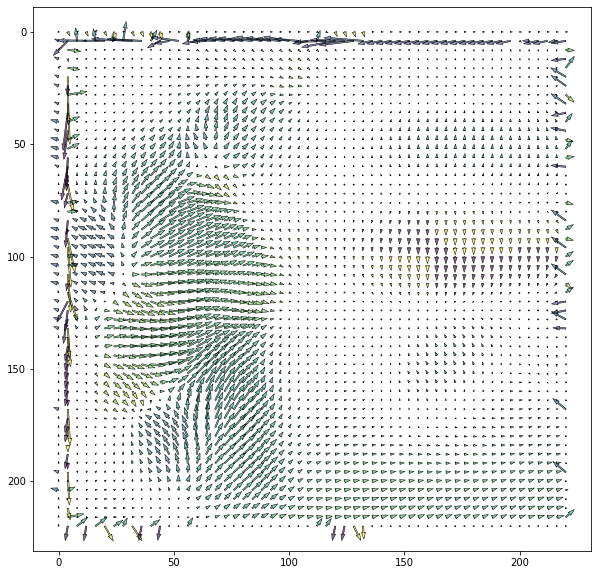

In [101]:
visualize_residuals(res)